In [1]:
# Setup
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

os.getcwd()

C:\Users\42874\AppData\Local\Continuum\anaconda3\envs\Michal\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\42874\AppData\Local\Continuum\anaconda3\envs\Michal\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\42874\AppData\Local\Continuum\anaconda3\envs\Michal\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


'C:\\Users\\42874\\Documents\\00_Cases\\Paymore'

In [2]:
# Options
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', None)

In [3]:
# Helpers

def relative_date(acq_date, date):
    
    acq_date_m =  pd.to_datetime(acq_date.apply(lambda x: x.strftime('%Y-%m')))
    date_m = pd.to_datetime(date.apply(lambda x: x.strftime('%Y-%m')))
    
    #months_from_acq = (date_m - acq_date_m).astype('timedelta64[M]')
    date_df = pd.DataFrame([acq_date_m, date_m])
    months_from_acq = date_df.apply(lambda x: date_diff_months(x.iloc[0], x.iloc[1]))
    
    output = months_from_acq.apply(lambda x: dt.date(2000,1,1) +  pd.DateOffset(months=x))
    return output


def dates_2_months(x):
    return x.strftime('%Y-%m')


def date_diff_months(start_date, end_date):
    return (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)


def calc_multiplier_EBIDTA(file):
    
    ebidta_dict = {}
        
    PRACTICES = get_practices(file)

    Practice_db = pd.read_excel(file, sheet_name=PRACTICES, engine='openpyxl', header=None)
    
    for practice in PRACTICES:
        #ebidta_dict[practice] = calc_EBITDA_multiplier(Practice_db[practice])
        ebidta_dict[practice] = get_EBIDTA(Practice_db[practice])
    
    return pd.DataFrame.from_dict(ebidta_dict).transpose()    
    
    
def get_practices(file):
    
    sht_names = file.sheet_names
    sht_visibility = [x.sheet_state for x in file._reader.book._sheets]

    sheet_df = pd.DataFrame([sht_names,sht_visibility]).transpose()
    visibility = [x=='visible' for x in sht_visibility]

    sht_names_visible = sheet_df[sheet_df.loc[:,1]=='visible']
    sht_names_visible = sht_names_visible.loc[:,0].to_list()
    PRACTICES = sht_names_visible[12:]
    
    return PRACTICES


def calc_EBIDTA_multiplier(x):
    
    y = x.copy()
    y.loc[8:12,4].replace(0, np.nan, inplace=True)
    
    return [y.loc[4,5] / y.loc[i,4] for i in range(8,13)]


def get_EBIDTA(x):
    
    y = x.copy()
    #y.loc[8:12,4].replace(0, np.nan, inplace=True)
    
    return [y.loc[i,4] for i in range(8,13)]

def change_to_long(df, id_vars, value):
    
    df_copy = df.copy()
    df_long = df_copy.melt(id_vars=id_vars, var_name="Date", value_name=value)
    df_long = df_long[~df_long.loc[:,value].isna()]
    df_long = df_long[~df_long.Acquisition_date.isna()]
    #df_long["Acquisition_date"] = df_long.Acquisition_date.apply(lambda x: x.strftime('%Y-%m-%d'))
    #df_long["Date"] = df_long.Date.apply(lambda x: x.strftime('%Y-%m-%d'))
    df_long["Relative_date"] = relative_date(df_long.Acquisition_date ,df_long.Date)
    
    return df_long


def summarize_tables(df, value):
    
    df_copy = df.copy()
    df_copy["gb_index"] = df_copy.Relative_date.dt.strftime('%Y')
    
    df_copy_gb =  df_copy.groupby(["Name","Bain_ID","gb_index"]).agg({
        value: np.sum
    })
    
    df_copy_gb = df_copy_gb.reset_index()
    
    df_copy_gb["gb_index"] = df_copy_gb["gb_index"].astype(int)
    df_copy_gb["gb_index"] += (-2000)
    
    df_copy_gb = df_copy_gb.rename(columns={"gb_index": "year"})
    
    return df_copy_gb


def populate_modeled_EBITDA(x, EBITDA_mult_table):
    
    multiplier = EBITDA_mult_table[EBITDA_mult_table.Bain_ID==x.Bain_ID]
    
    #return flatten_list([x.total_consideration/multiplier[i] for i in range(0,5)])
    return flatten_list([multiplier[i] for i in range(0,5)])

def flatten_list(t):
    return [item for sublist in t for item in sublist]

In [4]:
# Data import
Master_dataset = pd.read_excel("210921 - Pay more data request - Bain ID AAG v7.xlsx", sheet_name="Master dataset", usecols="C:W", skiprows=3, nrows=162, engine='openpyxl')
BainID_table =  pd.read_excel("210921 - Pay more data request - Bain ID AAG v7.xlsx", sheet_name="Performance post acqn", usecols="A:FA", skiprows=3, nrows=141, engine='openpyxl')

Main_dataset = pd.ExcelFile("July 2021 - Acquisition Summaries - AAG nopass.xlsx", engine='openpyxl')

Revenue_table =  pd.read_excel(Main_dataset, sheet_name="Post Acquisition Data Adj 1stYr", usecols="B:EY", skiprows=3, nrows=141, engine='openpyxl')
GrossProfit_table =  pd.read_excel(Main_dataset, sheet_name="Post Acquisition Data Adj 1stYr", usecols="B:EY", skiprows=154, nrows=141, engine='openpyxl')
EBITDA_table =  pd.read_excel(Main_dataset, sheet_name="Post Acquisition Data Adj 1stYr", usecols="B:EY", skiprows=306, nrows=141, engine='openpyxl')

In [5]:
# Data cleaning
Master_dataset = Master_dataset.iloc[1:,]
Master_dataset = Master_dataset[["Acquisition #", "Practices in deal", "Total consideration"]].rename(columns={
    "Acquisition #": "Bain_ID", 
    "Practices in deal": "Name",
    "Total consideration": "total_consideration"
})
Master_dataset = Master_dataset[~Master_dataset.total_consideration.isna()]

BainID_table = BainID_table[["Bain_ID","REVENUE"]].rename(columns={
    "REVENUE": "Name"
})


Revenue_table = Revenue_table.drop(columns=["Unnamed: 3"])
Revenue_table = Revenue_table.rename(columns={
    "REVENUE": "Name",
    "Unnamed: 2": "Acquisition_date"
})
Revenue_table = Revenue_table.merge(BainID_table, on="Name", how="left")


GrossProfit_table  = GrossProfit_table .drop(columns=["Unnamed: 2", "Unnamed: 3"])
GrossProfit_table = GrossProfit_table.rename(columns={
    "GROSS PROFIT": "Name"
})
GrossProfit_table = GrossProfit_table.merge(Revenue_table[["Name","Acquisition_date"]], on="Name", how="left")
GrossProfit_table = GrossProfit_table.merge(BainID_table, on="Name", how="left")


EBITDA_table = EBITDA_table.drop(columns=["Unnamed: 2", "Unnamed: 3"])
EBITDA_table = EBITDA_table.rename(columns={
    "EBITDA": "Name"
})
EBITDA_table = EBITDA_table.merge(Revenue_table[["Name","Acquisition_date"]], on="Name", how="left")
EBITDA_table = EBITDA_table.merge(BainID_table, on="Name", how="left")

In [6]:
# EBITDA multiplier 
EBITDA_multiplier = calc_multiplier_EBIDTA(Main_dataset)

# EBITDA_multiplier.to_csv("EBITDA_multiplier_dict.csv") # if new dataset will come
EBITDA_dict = pd.read_csv("EBITDA_multiplier_dict.csv")
EBITDA_dict = EBITDA_dict[~EBITDA_dict.Bain_ID.isna()]

EBITDA_multiplier = EBITDA_multiplier.merge(EBITDA_dict, left_index = True, right_on="Name")
EBITDA_multiplier_long = EBITDA_multiplier.melt(id_vars=["Name","Bain_ID"], var_name="Year", value_name="EBITDA_multiplier")
# EBITDA_multiplier_long["Year"] += 1

In [7]:
#df_copy = Revenue_table

#df_long = df_copy.melt(id_vars=["Name", "Acquisition_date","Bain_ID"], var_name="Date", value_name="Revenue")
#df_long = df_long[~df_long.loc[:,"Revenue"].isna()]
#df_long = df_long[~df_long.Acquisition_date.isna()]
#df_long.Date.apply(lambda x: x.strftime('%Y-%m-%d'))
#df_long = df_long[df_long.Bain_ID==4]
#df_long.head(20)

In [8]:
#relative_date(df_long.Acquisition_date ,df_long.Date)

In [9]:
#(pd.DataFrame([pd.to_datetime(df_long.Date.apply(lambda x: x.strftime('%Y-%m'))),pd.to_datetime(df_long.Acquisition_date.apply(lambda x: x.strftime('%Y-%m')))]).transpose()).apply(lambda x: date_diff_months(x.Acquisition_date,x.Date),axis=1)

In [10]:
Revenue_table_long = change_to_long(Revenue_table, ["Name", "Acquisition_date","Bain_ID"], "Revenue")
GrossProfit_table_long = change_to_long(GrossProfit_table, ["Name", "Acquisition_date","Bain_ID"], "Gross_profit")
EBITDA_table_long = change_to_long(EBITDA_table, ["Name", "Acquisition_date","Bain_ID"], "EBIDTA")

# Note - 2000-01-01 is a starting date. years in 1990s are the data before acquisition, year 2004 e.g. is a 5th year after the acquisition (2000 - 1st, 2001 - 2nd etc.)

In [11]:
Revenue_table_long 

,Name,Acquisition_date,Bain_ID,Date,Revenue,Relative_date
0,Maidenhead - Portman,2009-04-30,1.0,2009-01-01,42783.534667,1999-10-01
141,Maidenhead - Portman,2009-04-30,1.0,2009-02-01,42783.534667,1999-11-01
282,Maidenhead - Portman,2009-04-30,1.0,2009-03-01,42783.534667,1999-12-01
423,Maidenhead - Portman,2009-04-30,1.0,2009-04-01,42783.534667,2000-01-01
424,Henley - Coutrai House,2009-04-30,2.0,2009-04-01,45175.485000,2000-01-01
...,...,...,...,...,...,...
21230,Aviemore - Aviemore Dental Practice,2018-10-02,86.0,2021-07-01,82544.230000,2002-10-01
21231,London - London Perio,2018-09-28,87.0,2021-07-01,121933.290000,2002-11-01
21232,Perth - Caledonian Dental Care,2018-10-31,88.0,2021-07-01,287196.690000,2002-10-01
21233,Sheffield - Occudental,2018-11-01,90.0,2021-07-01,94674.010000,2002-09-01


In [12]:
Revenue_table_summ = summarize_tables(Revenue_table_long,"Revenue")
GrossProfit_table_summ = summarize_tables(GrossProfit_table_long,"Gross_profit")
EBITDA_table_summ = summarize_tables(EBITDA_table_long,"EBIDTA")

In [13]:
summary_table = Revenue_table_summ.merge(GrossProfit_table_summ, on=["Name","year"]).merge(EBITDA_table_summ, on=["Name","year"])

In [14]:
EBITDA_table_summ

,Name,Bain_ID,year,EBIDTA
0,Aston Clinton - ACDC,12.0,0,121354.335
1,Aston Clinton - ACDC,12.0,1,192485.140
2,Aston Clinton - ACDC,12.0,2,192013.140
3,Aston Clinton - ACDC,12.0,3,177127.230
4,Aston Clinton - ACDC,12.0,4,173679.540
...,...,...,...,...
506,York - Acomb,30.0,1,141187.050
507,York - Acomb,30.0,2,121339.070
508,York - Acomb,30.0,3,147533.830
509,York - Acomb,30.0,4,185749.860


In [15]:
qwe = Master_dataset.apply(lambda x: populate_modeled_EBITDA(x, EBITDA_multiplier), axis=1)
asd = qwe[qwe.apply(lambda x: len(x))>0]

modeled_EBIDTA=pd.DataFrame()

for i in range(len(asd)):
    modeled_EBIDTA=modeled_EBIDTA.append(pd.DataFrame(asd.iloc[i]).transpose())

modeled_EBIDTA.index = Master_dataset.loc[qwe.apply(lambda x: len(x))>0,:].Bain_ID

modeled_EBIDTA = modeled_EBIDTA.reset_index().melt(id_vars="Bain_ID", var_name="year", value_name="Exp_EBIDTA")

In [16]:
modeled_EBIDTA 

,Bain_ID,year,Exp_EBIDTA
0,1.0,0,NaN
1,2.0,0,NaN
2,3.0,0,108164.0
3,4.0,0,171571.0
4,5.0,0,97310.0
...,...,...,...
645,157.0,4,426277.0
646,158.0,4,430026.0
647,159.0,4,214501.0
648,160.0,4,214501.0


In [19]:
EBITDA_db = EBITDA_table_summ.merge(modeled_EBIDTA, on=["year","Bain_ID"], how="left")
EBITDA_db.year += 1
EBITDA_db = EBITDA_db.sort_values(["Bain_ID","year"])

EBITDA_db["Delta"] = EBITDA_db.Exp_EBIDTA - EBITDA_db.EBIDTA
EBITDA_db["Delta_pct"] = EBITDA_db.Delta / EBITDA_db.Exp_EBIDTA

EBITDA_db.to_csv("EBIDTA_analysis.csv")

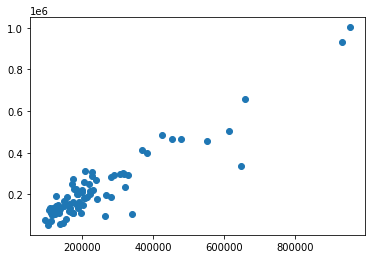

In [18]:
plot_data = EBITDA_db[EBITDA_db.year==1]
plt.scatter(plot_data.Exp_EBIDTA, plot_data.EBIDTA)